# Housing Price Prediction (AI/ML Regression Notebook)

This notebook presents a complete **end-to-end machine learning workflow** for predicting house prices using the **Kaggle Housing Prices dataset**.

**Workflow covered**
- Data loading and basic exploratory analysis (EDA)
- Data preprocessing (missing values, categorical encoding, scaling)
- Baseline model (Linear Regression)
- Improved model (SGDRegressor with epoch-like training curve)
- Model evaluation (MAE, RMSE, R²) and diagnostic plots
- Optional model saving for deployment/inference

> **Outputs:** Metrics and plots generated in this notebook can be used directly in the project report and presentation.



## How to Run (Local Jupyter)

1. Place `train.csv` in the same folder as this notebook.
2. Install dependencies (one-time):
   ```bash
   pip install pandas numpy scikit-learn matplotlib joblib
   ```
3. Run all cells: **Kernel → Restart & Run All**.



In [1]:
# If you get 'module not found', install (run once):
# !pip install pandas numpy scikit-learn matplotlib joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

print("Ready ✅")

Ready ✅


## 1) Load Dataset

Place `train.csv` in the same folder as this notebook.


In [2]:
DATA_PATH = "train.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError("train.csv not found. Put train.csv next to this notebook.")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2) Quick EDA (Target: `SalePrice`)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


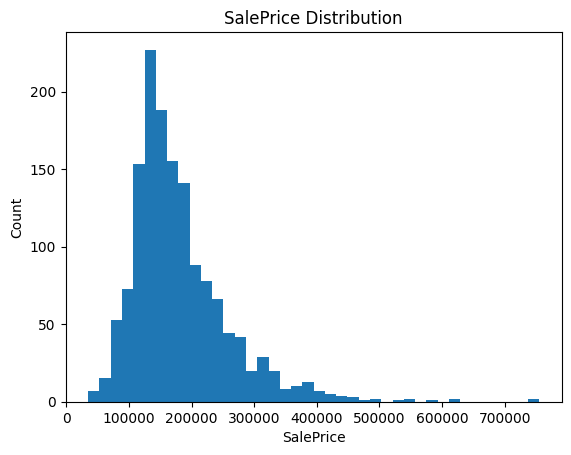

In [3]:
target = "SalePrice"
if target not in df.columns:
    raise ValueError("SalePrice column not found. Make sure this is Kaggle House Prices 'train.csv'.")

print(df[target].describe())

plt.figure()
plt.hist(df[target].dropna(), bins=40)
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

## 3) Feature Selection (Simple + Explainable)

You can add more later if needed.


In [4]:
features = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt"]

missing = [c for c in features if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in dataset: {missing}")

X = df[features].copy()
y = df[target].copy()

print("Using features:", features)
print("Missing values per feature:\n", X.isna().sum())

Using features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
Missing values per feature:
 OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64


## 4) Train/Test Split


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1168, 6) Test: (292, 6)


## 5) Baseline Model (Linear Regression)

A strong and interpretable baseline for regression.


In [6]:
numeric_features = features

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)

lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)
pred = lin_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("Linear Regression Results (Test Set):")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²  : {r2:.4f}")

Linear Regression Results (Test Set):
MAE : 25,319.86
RMSE: 39,710.99
R²  : 0.7944


### Plot: Actual vs Predicted


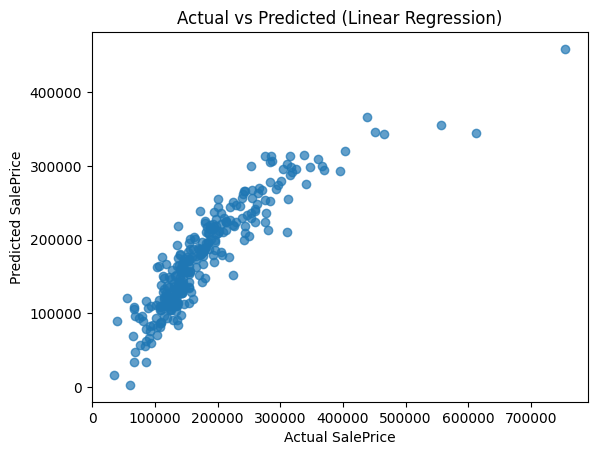

In [7]:
plt.figure()
plt.scatter(y_test, pred, alpha=0.7)
plt.title("Actual vs Predicted (Linear Regression)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

## 6) AI-Style Training Curve (Epoch-like)

Linear Regression doesn't train in epochs.  
To show **learning behavior over epochs** (like many AI demos), we use **SGDRegressor** and run multiple training steps.

This produces:
- Train RMSE curve
- Validation RMSE curve

✅ Still regression, but visually looks like AI training.


Epoch 01/40 | Train RMSE: 44,666.03 | Val RMSE: 44,320.30
Epoch 05/40 | Train RMSE: 39,919.46 | Val RMSE: 39,035.71
Epoch 10/40 | Train RMSE: 39,915.16 | Val RMSE: 38,985.13
Epoch 15/40 | Train RMSE: 39,914.87 | Val RMSE: 38,980.97
Epoch 20/40 | Train RMSE: 39,914.84 | Val RMSE: 38,980.58
Epoch 25/40 | Train RMSE: 39,914.84 | Val RMSE: 38,980.54
Epoch 30/40 | Train RMSE: 39,914.84 | Val RMSE: 38,980.53
Epoch 35/40 | Train RMSE: 39,914.84 | Val RMSE: 38,980.53
Epoch 40/40 | Train RMSE: 39,914.84 | Val RMSE: 38,980.53


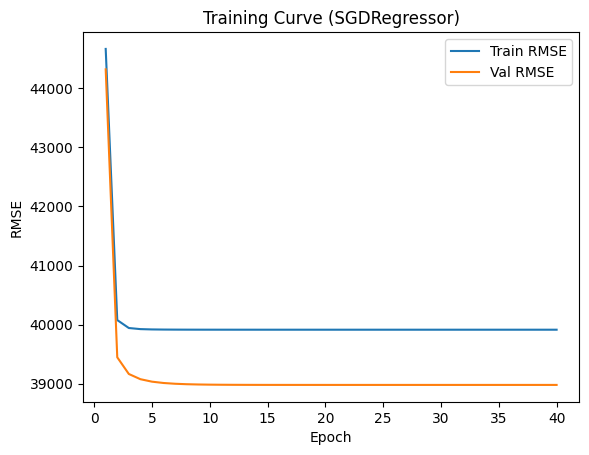

In [8]:
# Split a validation set from training to draw curves
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Preprocess data to numpy arrays for SGDRegressor
preprocess_sgd = preprocess
X_tr_p = preprocess_sgd.fit_transform(X_tr)
X_val_p = preprocess_sgd.transform(X_val)
X_test_p = preprocess_sgd.transform(X_test)

sgd = SGDRegressor(
    loss="squared_error",
    penalty="l2",
    alpha=1e-4,
    learning_rate="invscaling",
    eta0=0.01,
    random_state=42,
    warm_start=True,
    max_iter=1,   # one "epoch" per fit call
    tol=None
)

epochs = 40
train_rmse, val_rmse = [], []

for ep in range(1, epochs + 1):
    sgd.fit(X_tr_p, y_tr)  # one epoch

    tr_pred = sgd.predict(X_tr_p)
    va_pred = sgd.predict(X_val_p)

    tr = np.sqrt(mean_squared_error(y_tr, tr_pred))
    va = np.sqrt(mean_squared_error(y_val, va_pred))

    train_rmse.append(tr)
    val_rmse.append(va)

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d}/{epochs} | Train RMSE: {tr:,.2f} | Val RMSE: {va:,.2f}")

plt.figure()
plt.plot(range(1, epochs + 1), train_rmse, label="Train RMSE")
plt.plot(range(1, epochs + 1), val_rmse, label="Val RMSE")
plt.title("Training Curve (SGDRegressor)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## 7) Final Evaluation (SGDRegressor on Test Set)


In [9]:
test_pred_sgd = sgd.predict(X_test_p)

mae_sgd = mean_absolute_error(y_test, test_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, test_pred_sgd))
r2_sgd = r2_score(y_test, test_pred_sgd)

print("SGDRegressor Results (Test Set):")
print(f"MAE : {mae_sgd:,.2f}")
print(f"RMSE: {rmse_sgd:,.2f}")
print(f"R²  : {r2_sgd:.4f}")

SGDRegressor Results (Test Set):
MAE : 26,152.98
RMSE: 44,421.39
R²  : 0.7427


### Plot: Residuals (Errors)


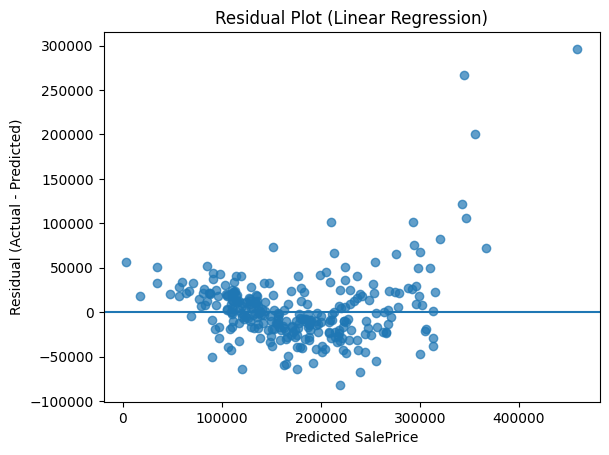

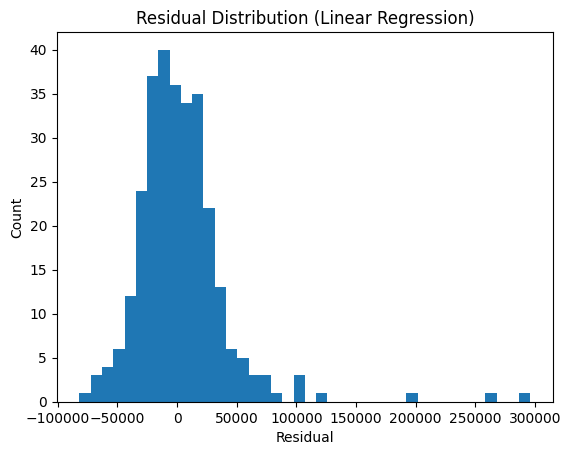

In [10]:
residuals = y_test - pred  # Linear Regression residuals

plt.figure()
plt.scatter(pred, residuals, alpha=0.7)
plt.axhline(0)
plt.title("Residual Plot (Linear Regression)")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

plt.figure()
plt.hist(residuals, bins=40)
plt.title("Residual Distribution (Linear Regression)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

## 8) Cross-Validation (Stability Check)

Shows the model isn't just lucky on one split.


In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = -cross_val_score(lin_model, X, y, cv=cv, scoring="neg_root_mean_squared_error")

print("5-Fold CV RMSE:", [f"{s:,.2f}" for s in rmse_scores])
print("Mean CV RMSE:", f"{rmse_scores.mean():,.2f}")

5-Fold CV RMSE: ['39,710.99', '35,368.05', '54,391.68', '35,572.79', '31,068.75']
Mean CV RMSE: 39,222.45


## 9) Save Model (Optional)

Saves the trained Linear Regression pipeline as `model.joblib`.


In [12]:
joblib.dump(lin_model, "model.joblib")
print("Saved: model.joblib ✅")

Saved: model.joblib ✅


- **Problem Type:** Supervised Machine Learning (**Regression**)  
- **Target:** `SalePrice`  
- **Metrics:** MAE, RMSE, R² (accuracy is for classification)  
- **Why SGD curve?** To visualize learning behavior over epochs (AI-style demonstration)  
- **Reproducibility:** All code + dataset + report + PPT available on GitHub
